Once all the images have been scraped, we run YOLO to detect the car in the image. We do this to reduce the noise passed down to the model further down the processing pipeline. Yolo will also help us detect shots of car details which we do not want to include in the trainingdata.

At this point I'm not sure yet if YOLO is the way to go, I'll include it anyway as it can run unattended without causing significant overhead. 

From playing around with this notebook we've established that it's difficult to minimize false negatives and false positives based on simple rules regarding the 'surface area' of an image. Yolo can help however by identifying the biggest object in the image which is likely to be the car. The generated bounding box can then be used in a further process. 

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from ultralytics import YOLO
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2  # For reading the image
##issue on UNIX systems with YOLO: https://github.com/ultralytics/yolov5/issues/1298

import sys
sys.path.append('../utils')
import config_handling as conf
import car_detection as cd


In [2]:
#there's a bug ON Unix systems and a backported version of LZMA is required. Test the OS here: 
if os.name == 'posix':
    print('A unix system was detected, please follow these steps to patch a known UNIX bug:')
    print('https://askubuntu.com/questions/1299255/how-can-i-solve-no-module-named-lzma')

A unix system was detected, please follow these steps to patch a known UNIX bug:
https://askubuntu.com/questions/1299255/how-can-i-solve-no-module-named-lzma


In [9]:
def render_images(image_paths, title):
    """
    Render a list of images using Matplotlib.

    Parameters:
    - image_paths (list): List of file paths to the images to display.
    """
    if not image_paths:
        print("No images to display.")
        return

    # Determine the grid size for subplots (e.g., 2 columns)
    num_images = len(image_paths)
    cols = 2
    rows = (num_images + cols - 1) // cols  # Calculate rows needed
    
    # Create a figure with dynamic size
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]  # Handle single image case
    fig.suptitle(title)
    i = 0
    # Loop through the image paths and render each image
    for image_name,v in image_paths.items():
        is_car, image_path, box, confidence, area = v
        try:
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(image_path), fontsize=10)
            axes[i].axis('off')  # Hide axes
            if is_car:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='red', facecolor='none')  # Use RGB color
                axes[i].add_patch(rect)
                label = f"{confidence:.2f}"
                axes[i].text(x_min, y_min, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))
                #add the box and confidence score to the image at axes[i]
        except Exception as e:
            axes[i].text(0.5, 0.5, "Error loading image", fontsize=12, ha='center')
            axes[i].axis('off')
            print(f"Error displaying {image_path}: {e}")
        i+=1
    # Hide any unused subplot axes
    for j in range(len(image_paths), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

NameError: name 'x_min' is not defined

In [4]:
# Load the YOLO model
yolomodel = YOLO('../models/yolo/yolov8n.pt')  # YOLOv8 nano for speed, or 'yolov8s.pt' for more accuracy


In [6]:
config = conf.read_config('../config/automotive.conf.ini')
imdir = config['settings']['image_directory']

In [20]:
brands = os.listdir(imdir)
brand = random.choice(brands)
models = os.listdir(os.path.join(imdir, brand))
model = random.choice(models)
d = os.path.join(imdir, brand, model)
listing = random.choice(os.listdir(d))
listingdir = os.path.join(imdir, brand, model, listing)
print(brand, model, listing)
keep = {}
reject = {}

for root, dirs, files in os.walk(listingdir):
    for file in files:
        image_path = os.path.join(root, file)
        details = cd.is_full_car(image_path, yolomodel)
        # Check if the image shows the entire outside of a car
        if details[0]:
            keep[file] = details
        else:
            reject[file] = details

porsche Taycan a6cb3316-d75e-4549-8d68-38e6a50f6ff3


In [ ]:
def tensor_to_coord(tensor, max): 
    v = math.ceil(tensor)

In [36]:
for k,v in keep.items():
    print(v[3])
    print(float(v[3]))
    #tensor_to_coord(v[23][0], 750)

tensor(0.8860)
0.8860440850257874
tensor(0.7112)
0.7112298011779785
tensor(0.5098)
0.5097824931144714
tensor(0.9291)
0.929121196269989
tensor(0.6918)
0.6917588710784912
tensor(0.8897)
0.8896552324295044
tensor(0.8425)
0.842481255531311
tensor(0.9290)
0.9290092587471008
tensor(0.9261)
0.92605060338974


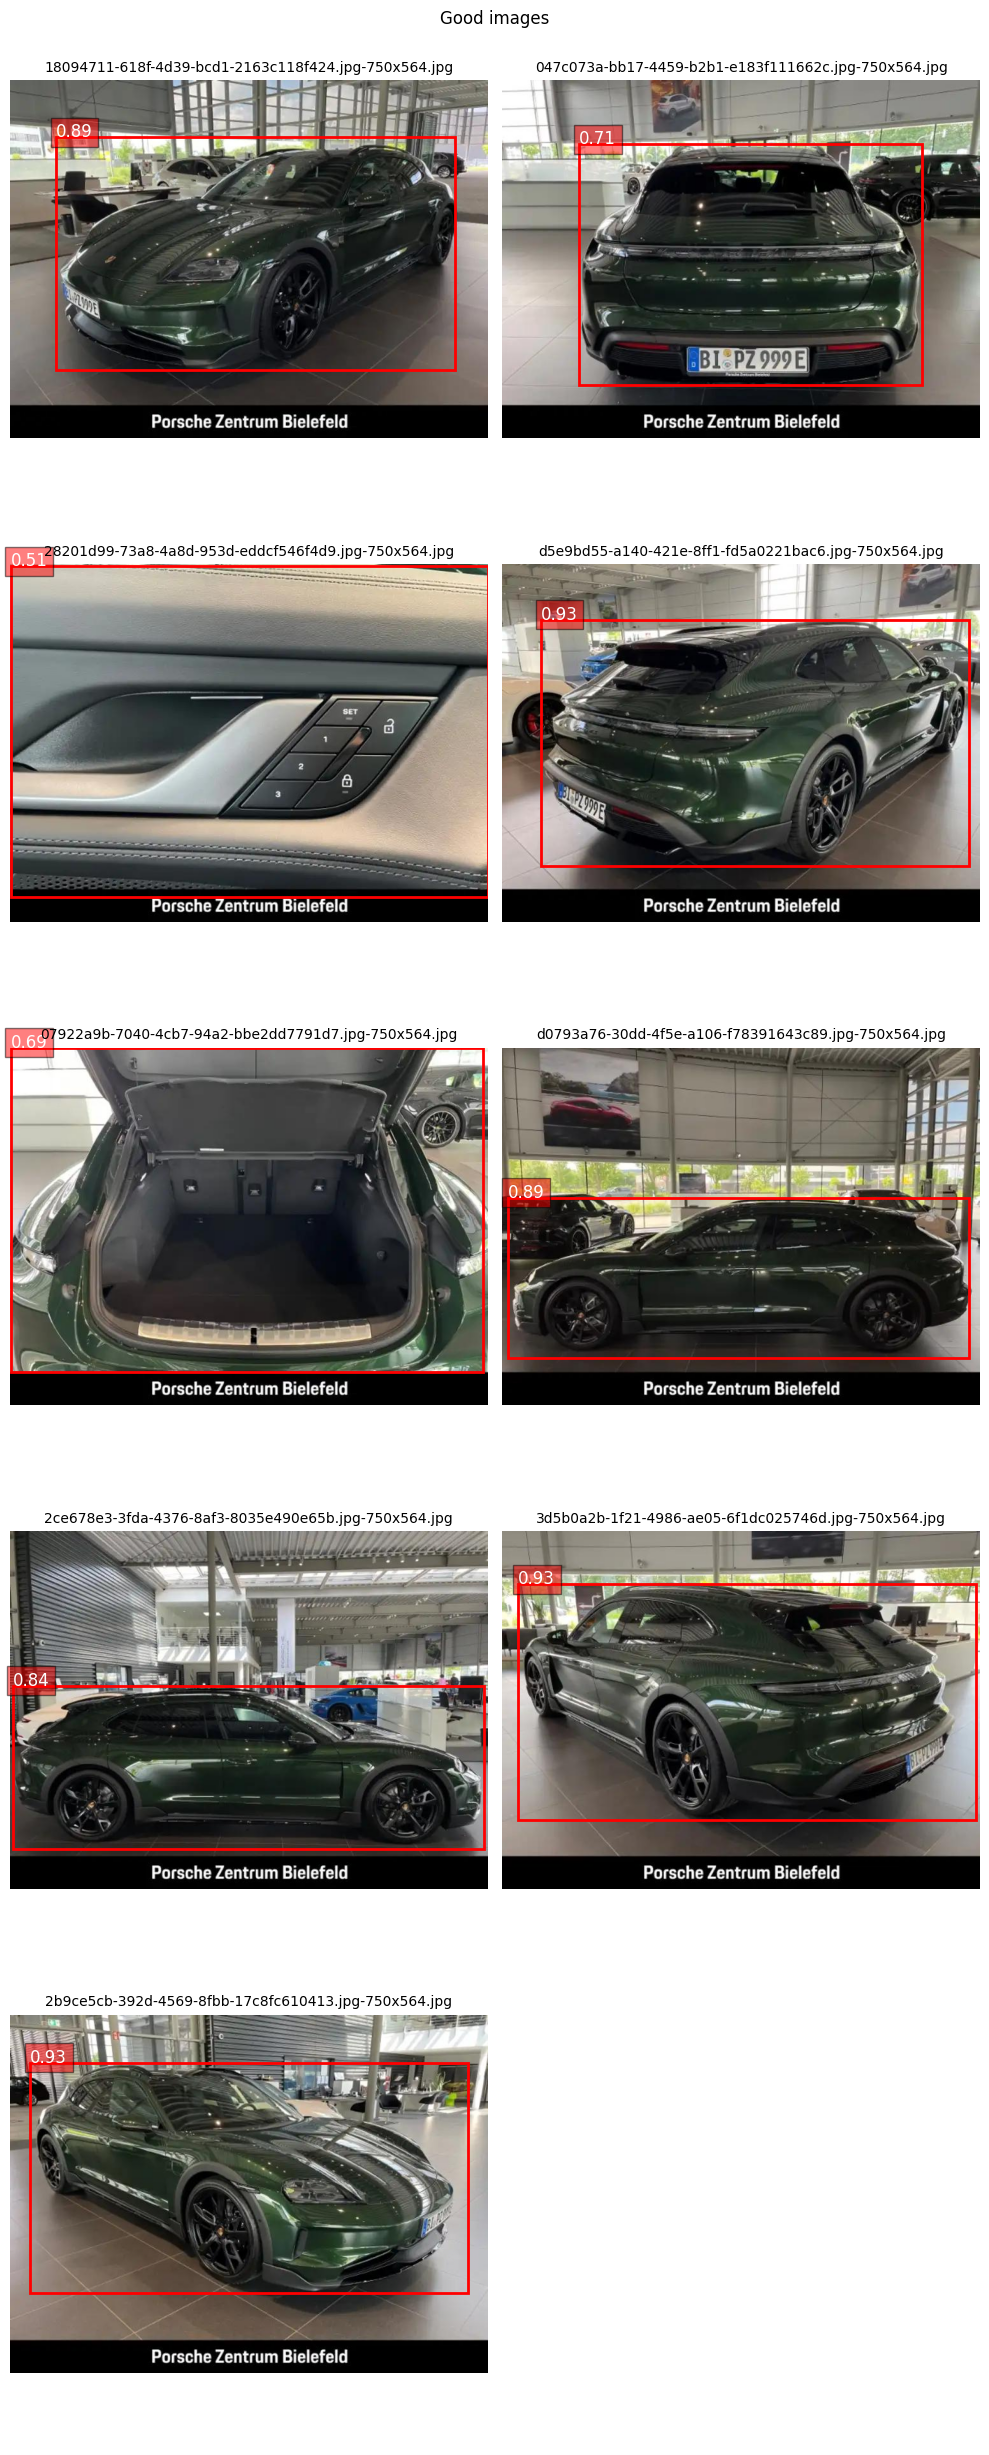

In [21]:
assert(len(keep) + len(reject) == len(files))

render_images(keep, "Good images")
render_images(reject, "crappy images")


In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2  # For reading the image

def generate_color_map(num_classes):
    """Generate a color map for the given number of classes."""
    colors = plt.cm.get_cmap('hsv', num_classes)
    return [colors(i) for i in range(num_classes)]

def visualize_detections(image_path, results):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Generate a color map for the detected classes
    num_classes = len(results[0].names)  # Assuming all results have the same class names
    color_map = generate_color_map(num_classes)

    # Iterate through the detection results
    for result in results:
        for box, cls_id, score in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            print(box)
            # Extract box coordinates
            x_min, y_min, x_max, y_max = box
            class_name = result.names[int(cls_id)]  # Get class name
            confidence = score  # Confidence score

            # Choose a color for the class
            color = color_map[int(cls_id)]

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor=color[:3], facecolor='none')  # Use RGB color
            ax.add_patch(rect)

            # Prepare the label with class name and confidence
            label = f"{class_name}: {confidence:.2f}"
            ax.text(x_min, y_min, label, fontsize=12, color='white', bbox=dict(facecolor=color[:3], alpha=0.5))

    # Show the image with detections
    plt.axis('off')  # Hide the axis
    plt.show()

issues = [reject[7]]
for issue in issues: 
    results = yolomodel(issue)  # Get the results from the YOLO model
    visualize_detections(issue, results)